This puts all the data from the feature generator, image_ids, and business_ids into a single pandas dataframe and then outputs a pickle file to store the result. Should be 465MB unzipped.

In [33]:
from pathlib2 import PosixPath
import pandas as pd

base_dir = '../data/'

limit = 234842
# uncomment to limit to 10 rows for testing..
#limit = 10

cols = []
feat_dtypes = {
}
images = []
for i in range(1024):
    col = 'f_' + str(i)
    cols.append(col)
    # We only need a float16 for the feature, not a float64 which is pandas default float. 
    # Makes a big difference when saving (1/4 size), but not in memory.
    feat_dtypes[col] = pd.np.float16
    
# Note that you need to use the c engine apparently to get the dypes to work.
features = pd.read_csv(base_dir + 'features_test.txt', delimiter=' ', nrows=limit, 
                       names=cols, index_col=False, engine='c', dtype=feat_dtypes)
biz_ids = pd.read_csv(base_dir + "test_photo_to_biz.csv", delimiter=',', nrows=limit, index_col=False)

img_f = open(base_dir + 'images_test.txt', 'r')

for i in range(len(features)):
    img = PosixPath(img_f.readline())
    i_period = img.name.find('.')
    images.append(int(img.name[:i_period]))

image_ids = pd.DataFrame(images, columns=['photo_id'])

img_f.close()
result = pd.concat([image_ids, features], axis=1, join='outer')
features
image_ids=None
img_f=None
images=None
new_result=None
new_result = pd.merge(biz_ids, result, how='left', sort=False, on=['photo_id'])
pd.to_pickle(new_result, base_dir + 'features_test.pickle')

# Test that things work
print result.loc[result['photo_id'] == 113970].f_0
print biz_ids.loc[biz_ids['photo_id'] == 113970].photo_id


0    0.498535
Name: f_0, dtype: float16
58461     113970
199790    113970
Name: photo_id, dtype: int64


In [36]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd

# Load the cached pandas pickle file.
base_dir = '../data/'
features = pd.read_pickle(base_dir + 'features_test.pickle')


In [37]:
biz_feat = features[['photo_id', 'business_id']].groupby(['business_id']).agg(['count'])

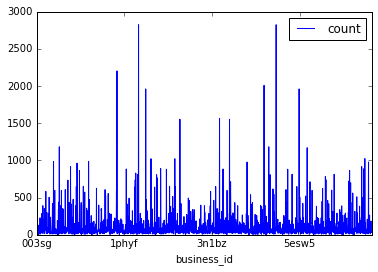

In [38]:
# Numbers of images per business.
biz_feat['photo_id'].plot()

# Looks like there is a lot of variation on the number of images per business.

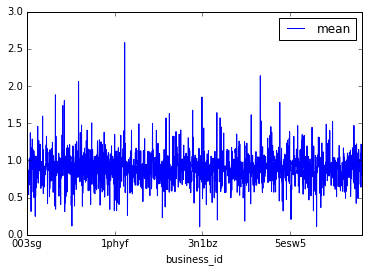

In [39]:
#Looking at the mean across business for feature 0.
biz_feat = features.groupby(['business_id']).agg(['mean'])
biz_feat.drop('photo_id', axis=1, inplace=True)
biz_feat['f_0'].plot()


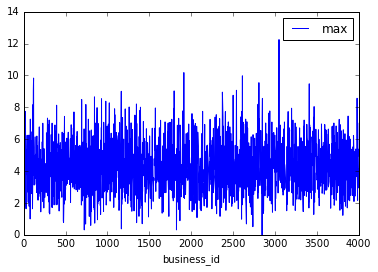

In [69]:
#Looking at the mean across business for feature 0.
biz_feat = features.groupby(['business_id']).agg(['max'])
biz_feat.drop('photo_id', axis=1, inplace=True)
biz_feat['f_0'].plot()

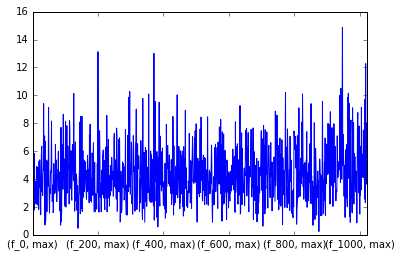

In [14]:
# Show the variance of features for a single business.
biz_feat = features.groupby(['business_id']).agg(['max'])
biz_feat.drop('photo_id', axis=1, inplace=True)
biz_feat.loc[4].plot()

In [34]:
new_result

,photo_id,business_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_1014,f_1015,f_1016,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023
0,317818,003sg,0.023666,2.591797,0.194336,0.047333,0.825684,0.352783,0.055847,0.213501,...,4.101562,0.906738,0.022308,0.329102,1.412109,2.333984,0.000000,1.880859,0.900879,0.463867
1,30679,003sg,0.792969,1.297852,0.000000,0.000000,2.232422,0.000000,1.247070,0.000000,...,0.054596,0.000000,0.409180,0.000000,1.692383,2.019531,0.000000,4.617188,0.000000,0.000000
2,455084,003sg,0.386719,1.740234,0.000000,0.002045,2.906250,0.000000,0.123596,0.000000,...,3.232422,0.000000,1.591797,0.000000,1.606445,0.139771,0.000000,0.000000,0.400879,0.072510
3,371381,003sg,0.656250,0.000000,1.446289,0.071411,0.007896,0.000000,0.000000,0.008789,...,0.000000,0.000000,0.000000,1.894531,0.136353,1.411133,1.913086,0.000000,0.000000,0.000000
4,86224,003sg,0.049133,1.583984,0.069153,0.416504,0.210571,0.865234,0.037170,0.019852,...,0.000000,0.000000,0.000000,2.550781,0.020828,0.282715,0.378418,0.000000,0.000000,0.097046
5,36076,003sg,0.342041,1.492188,0.060547,0.000000,2.322266,0.744629,0.050171,0.036957,...,1.366211,0.214600,1.196289,0.430420,0.016434,2.902344,0.242554,0.000000,0.000000,1.791992
6,46999,003sg,0.221313,1.453125,0.000000,0.000000,0.239258,0.000000,2.312500,0.000000,...,0.714844,0.000000,0.000000,0.000000,4.136719,0.000000,0.000000,0.000000,7.988281,0.000000
7,74896,003sg,0.696289,1.841797,0.000000,0.000000,0.966309,0.000000,4.003906,0.000000,...,0.000000,0.000000,0.687500,0.610840,2.363281,0.366455,0.000000,0.327393,0.979980,0.000000
8,169399,003sg,1.361328,4.296875,0.174561,0.000000,2.947266,0.000000,0.202393,0.290527,...,0.000000,0.000000,0.096680,0.000000,6.292969,0.057587,0.000000,0.000000,3.599609,0.000000
9,110581,003sg,0.000000,2.152344,0.000000,0.068726,0.037140,0.295166,2.128906,0.000000,...,1.128906,0.000000,0.000000,0.004887,1.685547,0.000000,0.000000,0.334961,0.436035,0.135376
